# Cohort Analyses

## References

|Link|Notes|
|---|---|
|https://finance.yahoo.com/news/hell-coming-mathematical-proof-185019616.html|Basic spread models|
|https://www.insidermonkey.com/blog/donald-trump-has-3-3-percent-chance-of-dying-from-coronavirus-817781/|Basic risk mdoel|

## Imports and Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
from ipypb import track
import datetime as dt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from celluloid import Camera
import os

In [2]:
pd.options.display.max_columns = 999

## Data

Data Sources (keep it simple and focus on building the models)
- https://covidtracking.com/api/
- New York Times

In [3]:
nytCountyData = "C:\\Users\\garfink2\\Documents\\data\\covid\\covid-19-data\\us-counties.csv"
folderOfJHUData = "C:\\Users\\garfink2\\Documents\\data\\covid\\COVID-19\\csse_covid_19_data\\csse_covid_19_daily_reports\\"
shp_USCounties = "C:\\Users\\garfink2\\Documents\\data\\basemap\\tl_2017_us_county\\tl_2017_us_county.shp"
shp_USStates = "C:\\Users\\garfink2\\Documents\\data\\basemap\\tl_2017_us_state\\tl_2017_us_state.shp"
excel_CountyPopulations = "C:\\Users\\garfink2\\Documents\\data\\basemap\\co-est2019-alldata.xlsx"

In [4]:
df_nytCountyData = pd.read_csv(nytCountyData)
gdf_USCounties = gpd.read_file(shp_USCounties)
gdf_USStates = gpd.read_file(shp_USStates)

In [5]:
df_countyPouplations = pd.read_excel(excel_CountyPopulations)

## Add in population data to counties

In [6]:
fips = []
for i,row in df_countyPouplations.iterrows():
    fip = int(f"{row['STATE']}{str(row['COUNTY']).zfill(3)}")
    fips.append(fip)
df_countyPouplations["fips"] = fips

In [7]:
df_countyPouplations["fips"]

0        1000
1        1001
2        1003
3        1005
4        1007
        ...  
3188    56037
3189    56039
3190    56041
3191    56043
3192    56045
Name: fips, Length: 3193, dtype: int64

In [8]:
gdf_USCounties = gdf_USCounties[["STATEFP","COUNTYFP","GEOID","NAME","NAMELSAD","geometry"]]

In [9]:
gdf_USCounties["GEOID"] = gdf_USCounties["GEOID"].astype("int")

In [10]:
len(fips)

3193

In [11]:
len(list(gdf_USCounties["GEOID"]))

3233

In [12]:
gdf_USCounties.sort_values("GEOID").head()

,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,geometry
1328,01,001,1001,Autauga,Autauga County,"POLYGON ((-86.90310 32.54063, -86.90311 32.540..."
1246,01,003,1003,Baldwin,Baldwin County,"POLYGON ((-87.99068 30.55549, -87.99051 30.560..."
1827,01,005,1005,Barbour,Barbour County,"POLYGON ((-85.42982 32.04598, -85.42985 32.046..."
3014,01,007,1007,Bibb,Bibb County,"POLYGON ((-87.31226 33.08622, -87.31218 33.087..."
855,01,009,1009,Blount,Blount County,"POLYGON ((-86.74919 33.99760, -86.74902 33.997..."


In [13]:
gdf_USCounties = pd.merge(left=gdf_USCounties,right=df_countyPouplations,left_on="GEOID",right_on="fips")

In [14]:
gdf_USCounties = gdf_USCounties[["STATEFP","COUNTYFP","GEOID","NAME","NAMELSAD","geometry","POPESTIMATE2019"]]

In [15]:
len(df_countyPouplations)

3193

In [16]:
len(gdf_USCounties)

3142

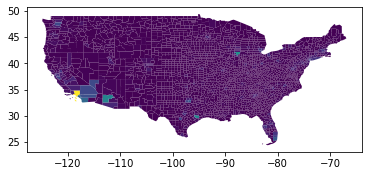

In [17]:
gdf_USCounties.cx[-125:-50, 20:70].plot("POPESTIMATE2019")

## Load the NYT Data

In [18]:
df_nytCountyData = df_nytCountyData.dropna(subset=["fips"])

In [19]:
df_nytCountyData["fips"] = df_nytCountyData["fips"].astype("int")

In [20]:
df_nytCountyData.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0


In [21]:
gdf_USCounties.head()

,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,geometry,POPESTIMATE2019
0,31,039,31039,Cuming,Cuming County,"POLYGON ((-97.01952 42.00410, -97.01952 42.004...",8846
1,53,069,53069,Wahkiakum,Wahkiakum County,"POLYGON ((-123.43639 46.23820, -123.44759 46.2...",4488
2,35,011,35011,De Baca,De Baca County,"POLYGON ((-104.56739 33.99757, -104.56772 33.9...",1748
3,31,109,31109,Lancaster,Lancaster County,"POLYGON ((-96.91060 40.95841, -96.91060 40.958...",319090
4,31,129,31129,Nuckolls,Nuckolls County,"POLYGON ((-98.27367 40.08940, -98.27367 40.089...",4148


In [22]:
gdf_countyTimeSeries = gpd.GeoDataFrame(pd.merge(left=df_nytCountyData,right=gdf_USCounties,left_on="fips",right_on="GEOID"))

In [23]:
gdf_countyTimeSeries['date'] = pd.to_datetime(gdf_countyTimeSeries['date'], errors='coerce')

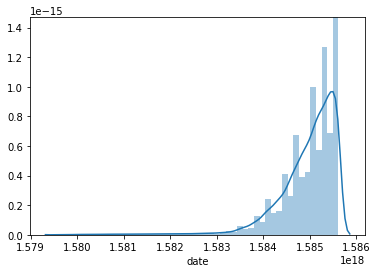

In [24]:
sns.distplot(gdf_countyTimeSeries["date"])

In [25]:
gpd.GeoDataFrame(gdf_countyTimeSeries[gdf_countyTimeSeries["fips"]==53061]).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
date,2020-01-21 00:00:00,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00,2020-03-17 00:00:00,2020-03-18 00:00:00,2020-03-19 00:00:00,2020-03-20 00:00:00,2020-03-21 00:00:00,2020-03-22 00:00:00,2020-03-23 00:00:00,2020-03-24 00:00:00,2020-03-25 00:00:00,2020-03-26 00:00:00,2020-03-27 00:00:00,2020-03-28 00:00:00,2020-03-29 00:00:00,2020-03-30 00:00:00,2020-03-31 00:00:00
county,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish,Snohomish
state,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington,Washington
fips,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061,53061
cases,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,3,5,8,17,18,26,36,45,61,69,107,132,154,175,199,265,309,347,384,446,480,518,613,633,778,913,912,1067,1126,1228
deaths,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,3,3,3,3,4,5,6,7,9,10,10,15,15,18,23,23,23,30,32
STATEFP,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53

Convert NYT data to date cases and date deaths

In [36]:
allFIPS = list(set(gdf_countyTimeSeries["fips"]))
dts = list(set(gdf_countyTimeSeries["date"]))
dts.sort()

In [37]:
dict_NYTData = {"fips":[]}
for dt in dts:
    columnNameBase = dt.strftime("%Y-%m-%d")
    casesColumn = f"{columnNameBase} Cases"
    deathsColumn = f"{columnNameBase} Deaths"
    casesData = []
    deathsData = []
    dict_NYTData[casesColumn] = casesData
    dict_NYTData[deathsColumn] = deathsData

In [38]:
for fips in allFIPS:
    dict_NYTData["fips"].append(fips)
    for dt in dts:
        columnNameBase = dt.strftime("%Y-%m-%d")
        casesColumn = f"{columnNameBase} Cases"
        deathsColumn = f"{columnNameBase} Deaths"
        cases = 0
        deaths = 0
        try:
            relevantColumn = gdf_countyTimeSeries[(gdf_countyTimeSeries["fips"]==fips) & (gdf_countyTimeSeries["date"]==dt)]
            cases = relevantColumn["cases"].iloc[0]
            deaths = relevantColumn["deaths"].iloc[0]
        except:
            cases = 0
            deaths = 0
        dict_NYTData[casesColumn].append(cases)
        dict_NYTData[deathsColumn].append(deaths)

In [39]:
df_NYTData = pd.DataFrame(dict_NYTData)

In [40]:
df_NYTData.head()

,fips,2020-01-21 Cases,2020-01-21 Deaths,2020-01-22 Cases,2020-01-22 Deaths,2020-01-23 Cases,2020-01-23 Deaths,2020-01-24 Cases,2020-01-24 Deaths,2020-01-25 Cases,2020-01-25 Deaths,2020-01-26 Cases,2020-01-26 Deaths,2020-01-27 Cases,2020-01-27 Deaths,2020-01-28 Cases,2020-01-28 Deaths,2020-01-29 Cases,2020-01-29 Deaths,2020-01-30 Cases,2020-01-30 Deaths,2020-01-31 Cases,2020-01-31 Deaths,2020-02-01 Cases,2020-02-01 Deaths,2020-02-02 Cases,2020-02-02 Deaths,2020-02-03 Cases,2020-02-03 Deaths,2020-02-04 Cases,2020-02-04 Deaths,2020-02-05 Cases,2020-02-05 Deaths,2020-02-06 Cases,2020-02-06 Deaths,2020-02-07 Cases,2020-02-07 Deaths,2020-02-08 Cases,2020-02-08 Deaths,2020-02-09 Cases,2020-02-09 Deaths,2020-02-10 Cases,2020-02-10 Deaths,2020-02-11 Cases,2020-02-11 Deaths,2020-02-12 Cases,2020-02-12 Deaths,2020-02-13 Cases,2020-02-13 Deaths,2020-02-14 Cases,2020-02-14 Deaths,2020-02-15 Cases,2020-02-15 Deaths,2020-02-16 Cases,2020-02-16 Deaths,2020-02-17 Cases,2020-02-17 Deaths,2020-02-18 Cases,2020-02-18 Deaths,2020-02-19 Cases,2020-02-19 Deaths,2020-02-20 Cases,2020-02-20 Deaths,2020-02-21 Cases,2020-02-21 Deaths,2020-02-22 Cases,2020-02-22 Deaths,2020-02-23 Cases,2020-02-23 Deaths,2020-02-24 Cases,2020-02-24 Deaths,2020-02-25 Cases,2020-02-25 Deaths,2020-02-26 Cases,2020-02-26 Deaths,2020-02-27 Cases,2020-02-27 Deaths,2020-02-28 Cases,2020-02-28 Deaths,2020-02-29 Cases,2020-02-29 Deaths,2020-03-01 Cases,2020-03-01 Deaths,2020-03-02 Cases,2020-03-02 Deaths,2020-03-03 Cases,2020-03-03 Deaths,2020-03-04 Cases,2020-03-04 Deaths,2020-03-05 Cases,2020-03-05 Deaths,2020-03-06 Cases,2020-03-06 Deaths,2020-03-07 Cases,2020-03-07 Deaths,2020-03-08 Cases,2020-03-08 Deaths,2020-03-09 Cases,2020-03-09 Deaths,2020-03-10 Cases,2020-03-10 Deaths,2020-03-11 Cases,2020-03-11 Deaths,2020-03-12 Cases,2020-03-12 Deaths,2020-03-13 Cases,2020-03-13 Deaths,2020-03-14 Cases,2020-03-14 Deaths,2020-03-15 Cases,2020-03-15 Deaths,2020-03-16 Cases,2020-03-16 Deaths,2020-03-17 Cases,2020-03-17 Deaths,2020-03-18 Cases,2020-03-18 Deaths,2020-03-19 Cases,2020-03-19 Deaths,2020-03-20 Cases,2020-03-20 Deaths,2020-03-21 Cases,2020-03-21 Deaths,2020-03-22 Cases,2020-03-22 Deaths,2020-03-23 Cases,2020-03-23 Deaths,2020-03-24 Cases,2020-03-24 Deaths,2020-03-25 Cases,2020-03-25 Deaths,2020-03-26 Cases,2020-03-26 Deaths,2020-03-27 Cases,2020-03-27 Deaths,2020-03-28 Cases,2020-03-28 Deaths,2020-03-29 Cases,2020-03-29 Deaths,2020-03-30 Cases,2020-03-30 Deaths,2020-03-31 Cases,2020-03-31 Deaths
0,41003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2,0,2,0,2,0,2,0,4,0,4,0,4,0,6,0,6,0,6,0,9,0,9,0,10,0,12,1
1,41005,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,2,0,6,0,6,0,6,0,10,0,11,0,12,0,14,0,17,1,21,2,21,2,31,2,36,2,39,2,40,3,50,3
2,41007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2,0,2,0,3,0,3,0,3,0,3,0
3,41009,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0
4,41017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,3,0,4,0,6,0,6,0,6,0,6,0,8,0,9,0,10,0,10,0,10,0,10,0,15,0,18,0,20,0,23,0,25,0,24,0


In [41]:
gdf_NYTTimeSeries = gpd.GeoDataFrame(pd.merge(left=df_NYTData,right=gdf_USCounties,left_on="fips",right_on="GEOID"))

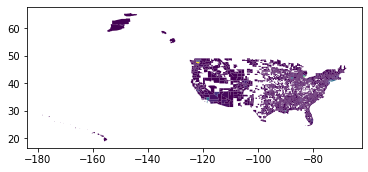

In [43]:
gdf_NYTTimeSeries.plot("2020-03-31 Deaths")

In [140]:
gdf_countyTimeSeries.head()

,date,county,state,fips,cases,deaths,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,geometry,POPESTIMATE2019
0,2020-01-21,Snohomish,Washington,53061,1,0,53,061,53061,Snohomish,Snohomish County,"POLYGON ((-122.34309 48.03653, -122.34086 48.0...",822083
1,2020-01-22,Snohomish,Washington,53061,1,0,53,061,53061,Snohomish,Snohomish County,"POLYGON ((-122.34309 48.03653, -122.34086 48.0...",822083
2,2020-01-23,Snohomish,Washington,53061,1,0,53,061,53061,Snohomish,Snohomish County,"POLYGON ((-122.34309 48.03653, -122.34086 48.0...",822083
3,2020-01-24,Snohomish,Washington,53061,1,0,53,061,53061,Snohomish,Snohomish County,"POLYGON ((-122.34309 48.03653, -122.34086 48.0...",822083
4,2020-01-25,Snohomish,Washington,53061,1,0,53,061,53061,Snohomish,Snohomish County,"POLYGON ((-122.34309 48.03653, -122.34086 48.0...",822083


In [124]:
def filterByDate(gdf,dateColumn="date",month=3,day=27,year=2020,operator="="):
    filterDate = dt.datetime(month=month,day=day,year=year)
    if operator == "=":
        gdf = gdf[gdf[dateColumn] == filterDate]
    elif operator == "<":
        gdf = gdf[gdf[dateColumn] < filterDate]
    elif operator == "<=":
            gdf = gdf[gdf[dateColumn] <= filterDate]
    elif operator == ">":
            gdf = gdf[gdf[dateColumn] > filterDate]
    elif operator == ">=":
            gdf = gdf[gdf[dateColumn] >= filterDate]
    else:
        raise(Exception("error, operator not recognized"))
    return gdf

Text(0.5, 1, 'Number of confirmed COVID-19 Cases, 29 March 2020')

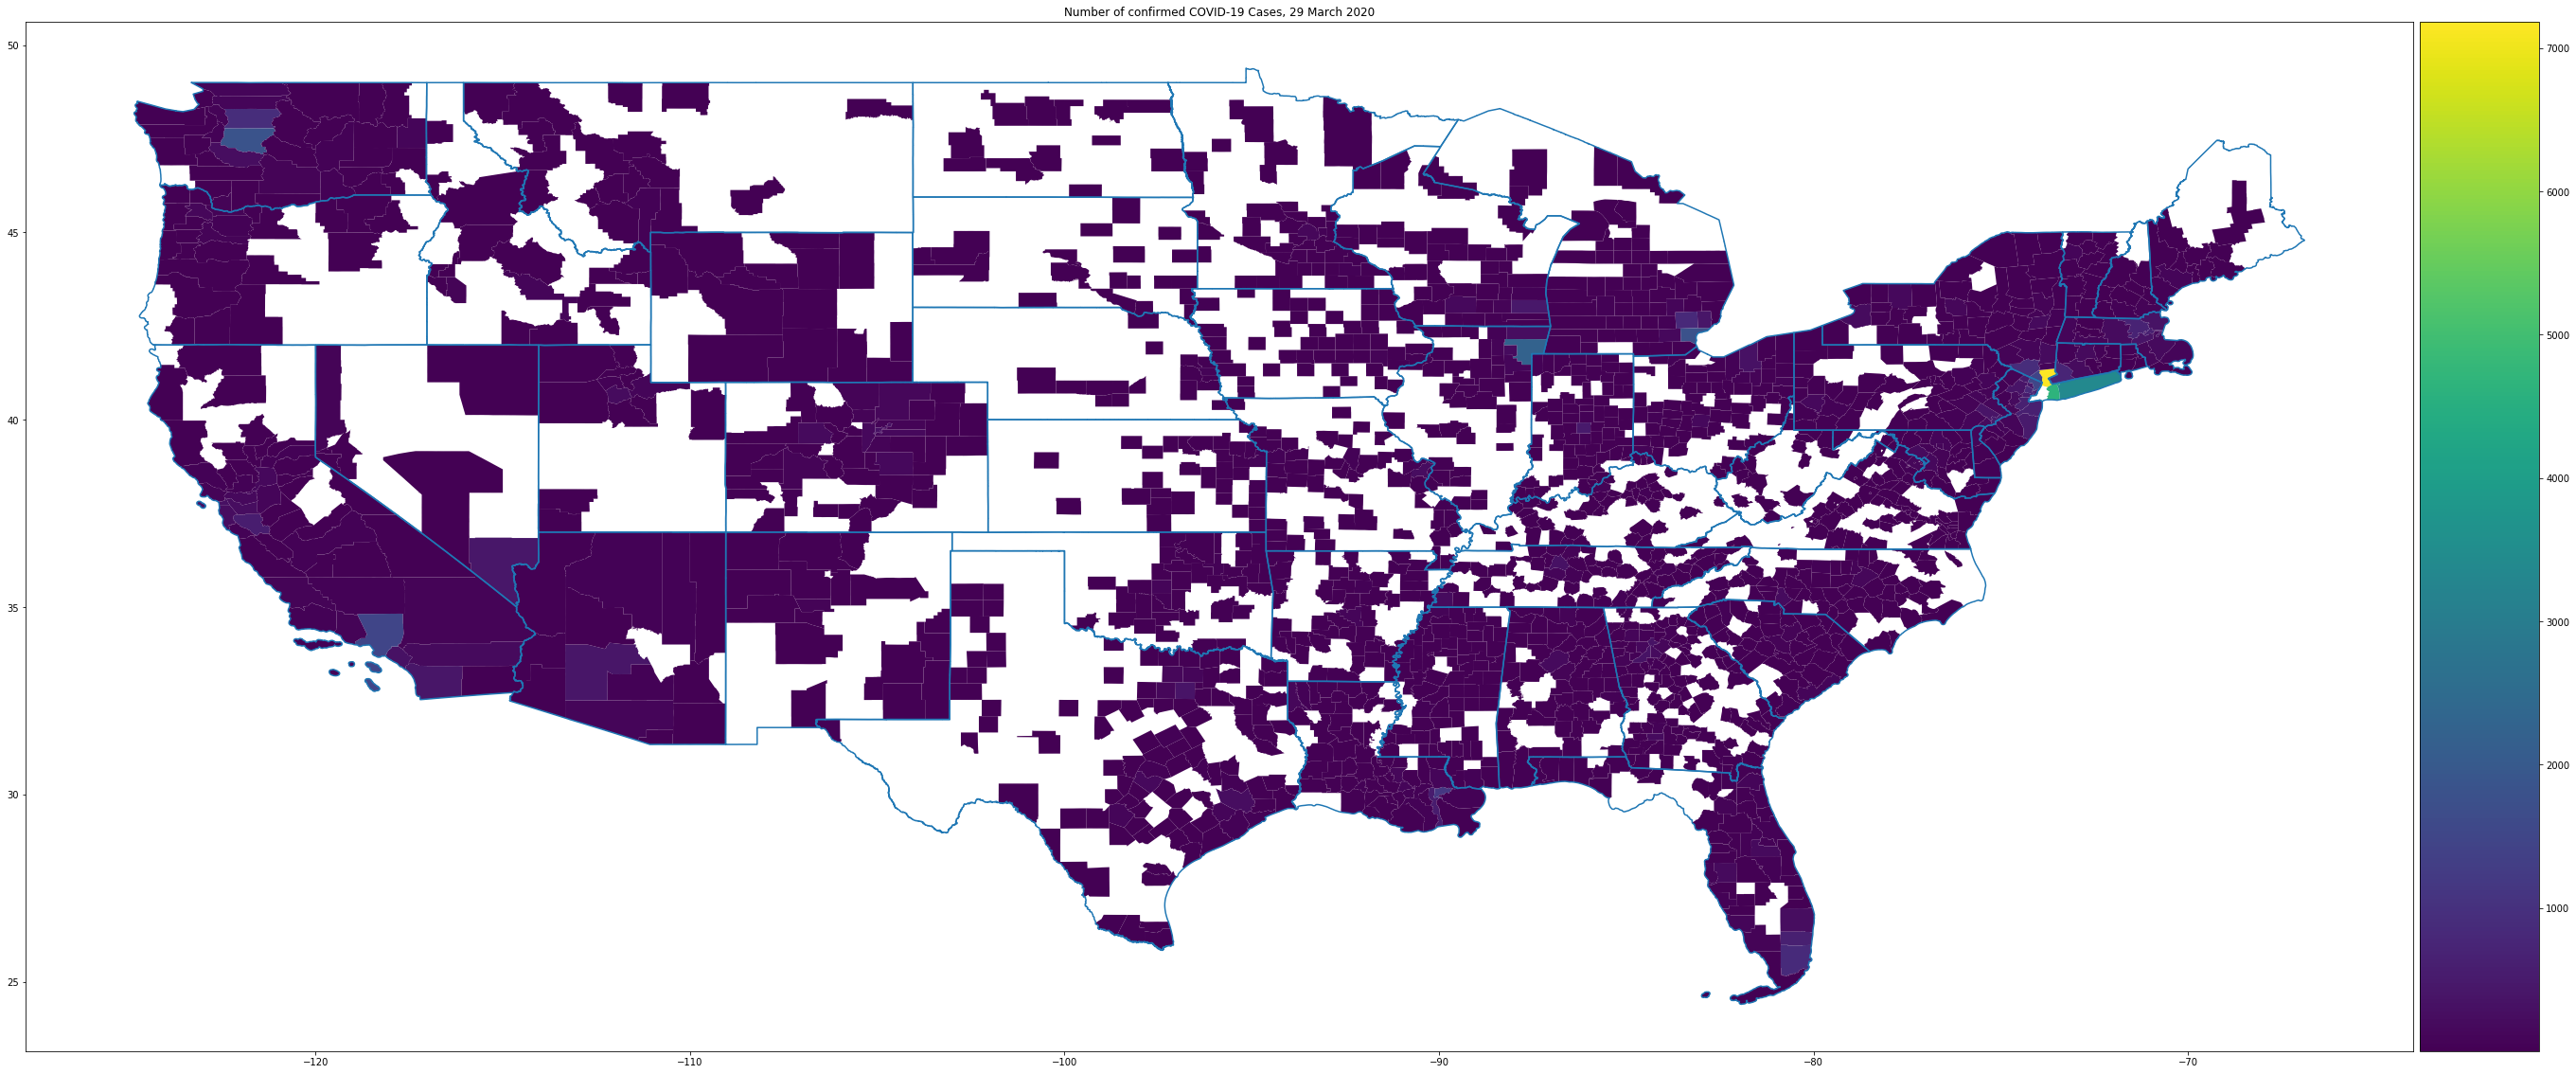

In [125]:
fig,ax = plt.subplots(figsize=(50,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
filterByDate(gdf_countyTimeSeries).cx[-125:-50, 20:70].plot("cases",ax=ax,cax=cax,legend="True")
gdf_USStates.boundary.cx[-125:-50, 20:70].plot(ax=ax)
ax.set_title("Number of confirmed COVID-19 Cases, 29 March 2020")

In [126]:
def plotController(month=3,day=1,year=2020):
    fig,ax = plt.subplots(figsize=(50,20))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    filterByDate(gdf_countyTimeSeries,year=year,month=month,day=day).cx[-125:-50, 20:70].plot("cases",ax=ax,cax=cax,legend="True")
    gdf_USStates.boundary.cx[-125:-50, 20:70].plot(ax=ax)

In [127]:
interact(plotController,
         month=widgets.IntSlider(min=1,max=12,step=1,value=3),
         day=widgets.IntSlider(min=1,max=31,step=1,value=27),
         year=widgets.IntSlider(min=2019,max=2021,step=1,value=2020),
        )

interactive(children=(IntSlider(value=3, description='month', max=12, min=1), IntSlider(value=27, description=…

<function __main__.plotController(month=3, day=1, year=2020)>

## Load the JHU Data

In [128]:
dailyUpdates = os.listdir(folderOfJHUData)

In [129]:
dailyUpdatesDict = {}
for file in dailyUpdates:
    if ".csv" in file:
        dailyUpdatesDict[dt.datetime.strptime(file.split('.')[0],"%m-%d-%Y")] = file

Now let's use the JHU data to generate a dataframe for counties of: FIPS, County Name, Date1 Confirmed, Date1 Deaths, Date1 Recovered

In [136]:
errorPrint = False
gdf_JHUData = gdf_USCounties.copy(deep=True)
for dt,filename in dailyUpdatesDict.items():
    columnNameBase = dt.strftime("%Y-%m-%d")
    filePath = f"{folderOfJHUData}{filename}"
    df_daily = pd.read_csv(filePath)
    if "FIPS" in df_daily.columns:
        df_daily = df_daily.dropna(subset=["FIPS"])
        df_daily = df_daily[["FIPS","Confirmed","Deaths","Recovered"]]
        df_daily = df_daily.dropna(subset=["FIPS"])
        df_daily["FIPS"] = df_daily["FIPS"].astype("int")
        df_daily.columns = ["FIPS",f"{columnNameBase} Confirmed",f"{columnNameBase} Deaths",f"{columnNameBase} Recovered"]
        gdf_JHUData = pd.merge(left=gdf_JHUData,right=df_daily,left_on="GEOID",right_on="FIPS")
    elif errorPrint:
        print(f"could not process {filename}")

In [137]:
gdf_JHUData.head()

,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,geometry,POPESTIMATE2019,FIPS_x,2020-03-22 Confirmed,2020-03-22 Deaths,2020-03-22 Recovered,FIPS_y,2020-03-23 Confirmed,2020-03-23 Deaths,2020-03-23 Recovered,FIPS_x,2020-03-24 Confirmed,2020-03-24 Deaths,2020-03-24 Recovered,FIPS_y,2020-03-25 Confirmed,2020-03-25 Deaths,2020-03-25 Recovered,FIPS_x,2020-03-26 Confirmed,2020-03-26 Deaths,2020-03-26 Recovered,FIPS_y,2020-03-27 Confirmed,2020-03-27 Deaths,2020-03-27 Recovered,FIPS_x,2020-03-28 Confirmed,2020-03-28 Deaths,2020-03-28 Recovered,FIPS_y,2020-03-29 Confirmed,2020-03-29 Deaths,2020-03-29 Recovered,FIPS_x,2020-03-30 Confirmed,2020-03-30 Deaths,2020-03-30 Recovered,FIPS_y,2020-03-31 Confirmed,2020-03-31 Deaths,2020-03-31 Recovered,FIPS,2020-04-01 Confirmed,2020-04-01 Deaths,2020-04-01 Recovered
0,31,109,31109,Lancaster,Lancaster County,"POLYGON ((-96.91060 40.95841, -96.91060 40.958...",319090,31109,2,0,0,31109,2,0,0,31109,2,0,0,31109,3,0,0,31109,3,0,0,31109,3,0,0,31109,4,0,0,31109,4,0,0,31109,8,0,0,31109,8,0,0,31109,9,0,0
1,46,099,46099,Minnehaha,Minnehaha County,"POLYGON ((-97.12928 43.58683, -97.12920 43.596...",193134,46099,5,0,0,46099,5,0,0,46099,5,0,0,46099,13,0,0,46099,16,0,0,46099,18,0,0,46099,21,0,0,46099,25,0,0,46099,28,0,0,46099,31,0,0,46099,40,0,0
2,39,063,39063,Hancock,Hancock County,"POLYGON ((-83.88076 41.08036, -83.88076 41.081...",75783,39063,1,0,0,39063,1,0,0,39063,1,0,0,39063,1,0,0,39063,2,0,0,39063,2,0,0,39063,3,0,0,39063,3,0,0,39063,3,0,0,39063,5,0,0,39063,6,0,0
3,48,189,48189,Hale,Hale County,"POLYGON ((-102.08763 34.02656, -102.08779 34.0...",33406,48189,0,0,0,48189,0,0,0,48189,0,0,0,48189,1,0,0,48189,1,0,0,48189,1,0,0,48189,1,0,0,48189,1,0,0,48189,1,0,0,48189,1,0,0,48189,1,0,0
4,01,027,1027,Clay,Clay County,"POLYGON ((-85.97879 33.32757, -85.97876 33.328...",13235,1027,0,0,0,1027,0,0,0,1027,0,0,0,1027,1,0,0,1027,1,0,0,1027,1,0,0,1027,2,0,0,1027,2,0,0,1027,2,0,0,1027,2,0,0,1027,2,0,0


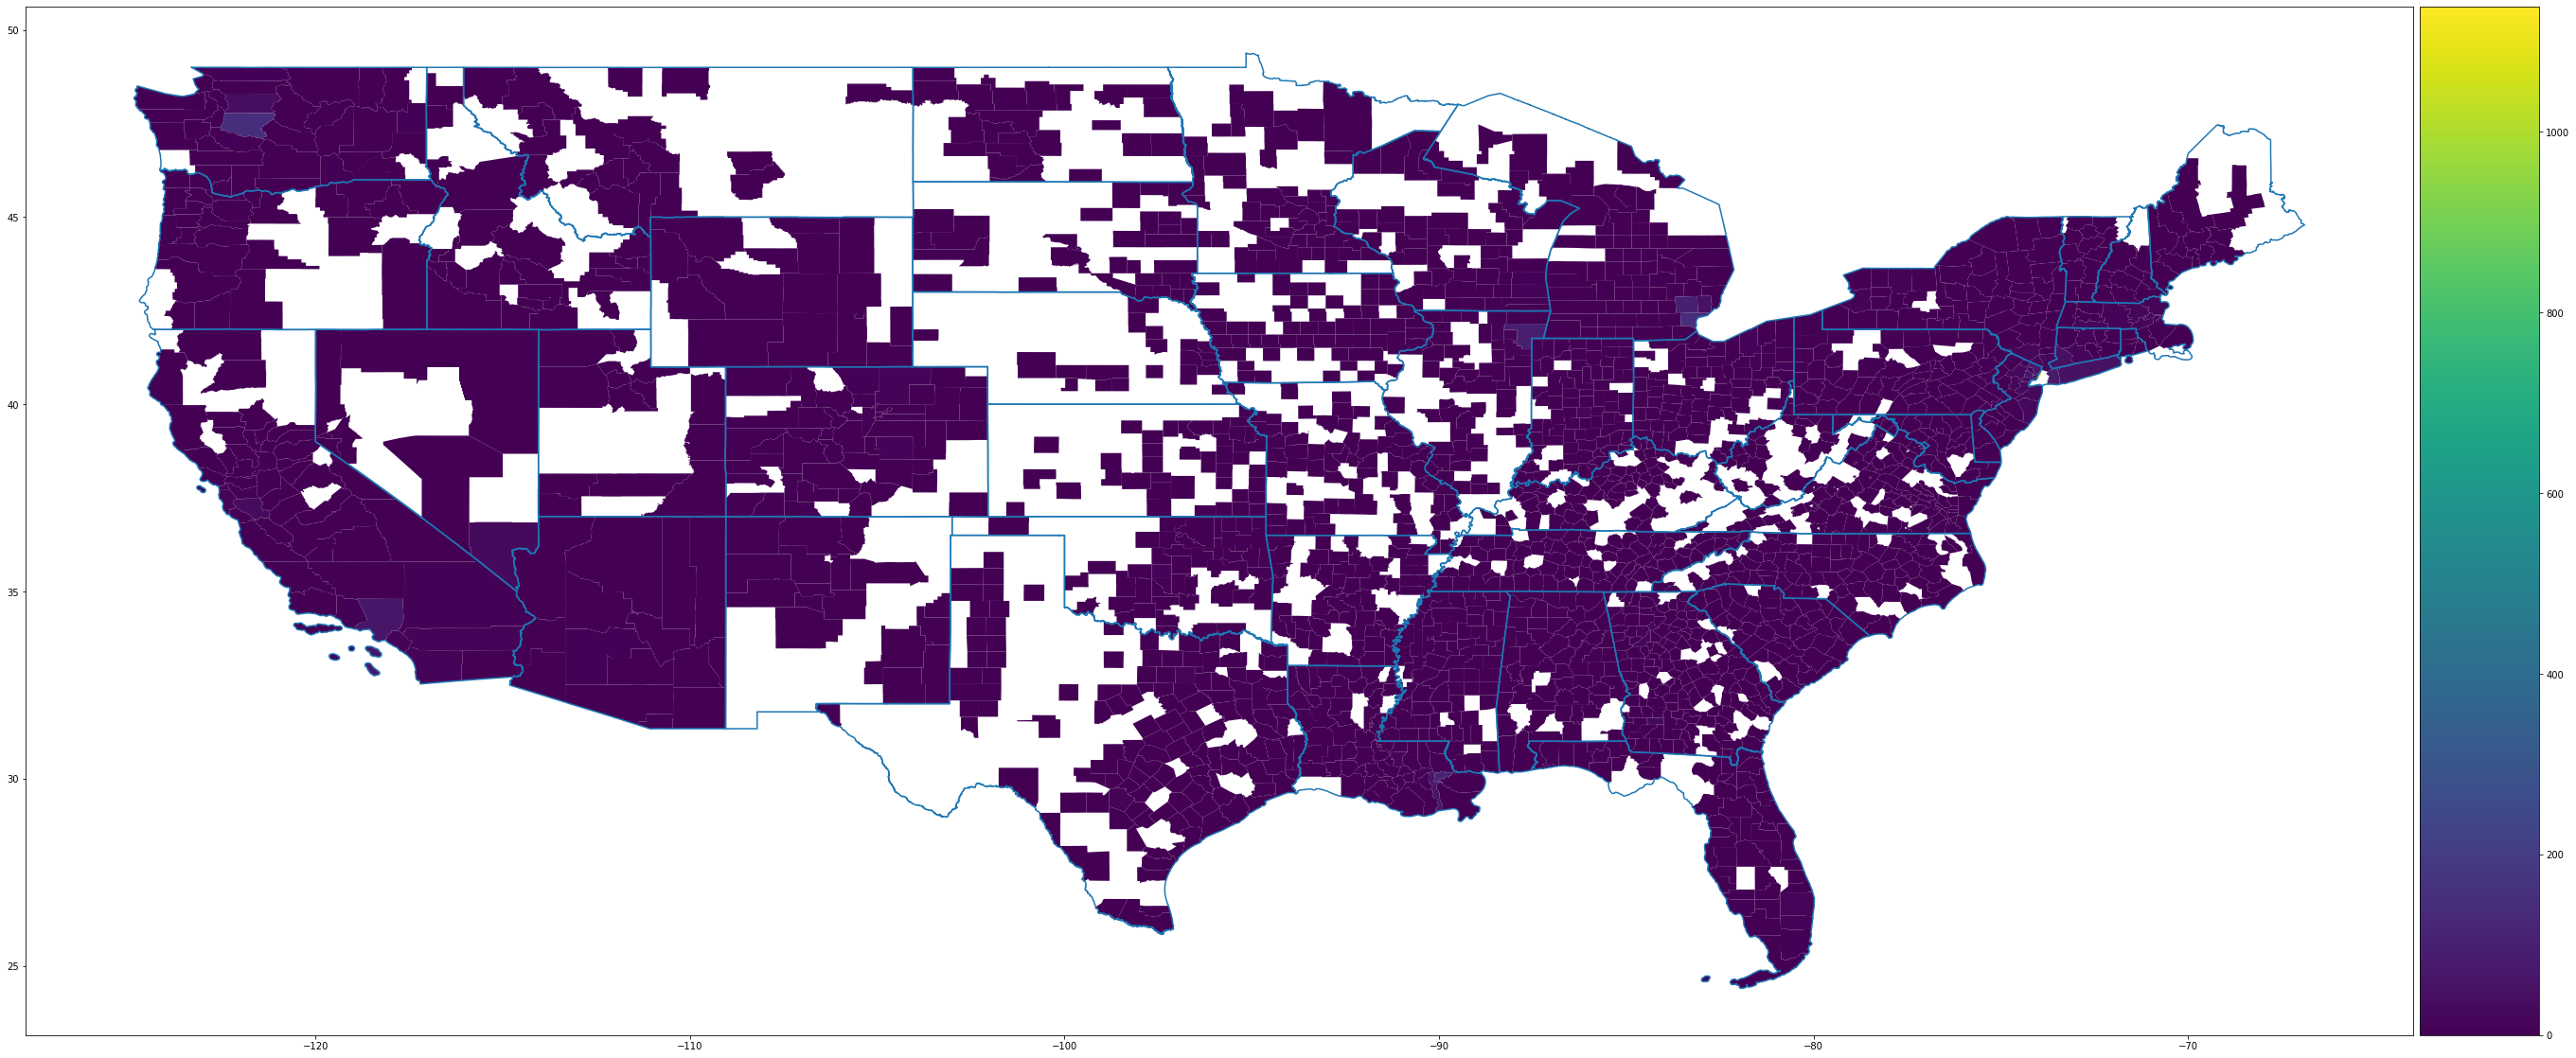

In [139]:
fig,ax = plt.subplots(figsize=(50,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
gdf_JHUData.cx[-125:-50, 20:70].plot("2020-04-01 Deaths",ax=ax,cax=cax,legend="True")
gdf_USStates.boundary.cx[-125:-50, 20:70].plot(ax=ax)

## Assumptions

In [44]:
rate_fatality = 0.8/100 # https://finance.yahoo.com/news/hell-coming-mathematical-proof-185019616.html
days_to_onset = 5
days_to_hospitalization = 10
days_to_outcome = 24

## Analyses

Estimating cohort risk

- Assume $P_{{infection}}$ is homogenous and homogenous both spatially and across population subsets
- Specify assumed rates for $P_{{{{hospitalization}}_{{age}}}}$ and $P_{{{{death}}_{{age}}}}$
- Specify assumed rates for $P_{{{{absence}}_{{non-illness}}}}$

SIR Model

https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

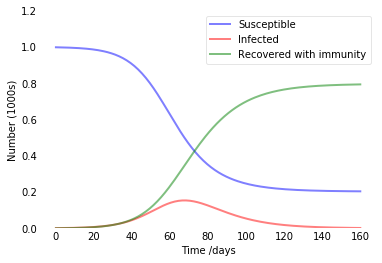

In [45]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./10 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

Take a look at https://github.com/Lewuathe/COVID19-SIR

Also take a look at https://towardsdatascience.com/social-distancing-to-slow-the-coronavirus-768292f04296

https://github.com/closedloop-ai/cv19index

https://github.com/CodeForPhilly/chime

https://github.com/coronafighter/coronaSEIR

Playing with SIR models from "Mathematical Epidemiology" page 23

$$S(t+\Delta t) = S(t) - \beta S(t)I(t)\Delta t$$

$$I(t+\Delta t) = I(t) + \beta S(t)I(t)\Delta t - \gamma I(t)\Delta t$$

$$\mathbf{R}_0 = \frac{\beta N}{\gamma}$$

In [46]:
N = 7_781_984 # Population
γ = 0.2 # Recovery rate, meaning that the mean infectious period is 1/γ
R0 = 3 # Basic reproduction number
β = R0 * γ / N # Transmission rate per capita
Δt = 0.1 # Time step for the solution method

In [47]:
I = 1
S = N
Is = [I]
Ss = [S]
ts = np.arange(0,100,Δt)
for t in ts:
    if S < 0:
        S = 0
    if I < 0:
        I = 0
    S_new = S - β * S * I * Δt
    I_new = I + β * S * I * Δt - γ * I * Δt
    S = S_new
    I = I_new
    Ss.append(S)
    Is.append(I)
del Ss[-1] # kludge because for loop is not inclusive
del Is[-1]

Text(0.5, 1.0, 'Simple S.I.R. Model\nγ=0.2,$R_0$=3')

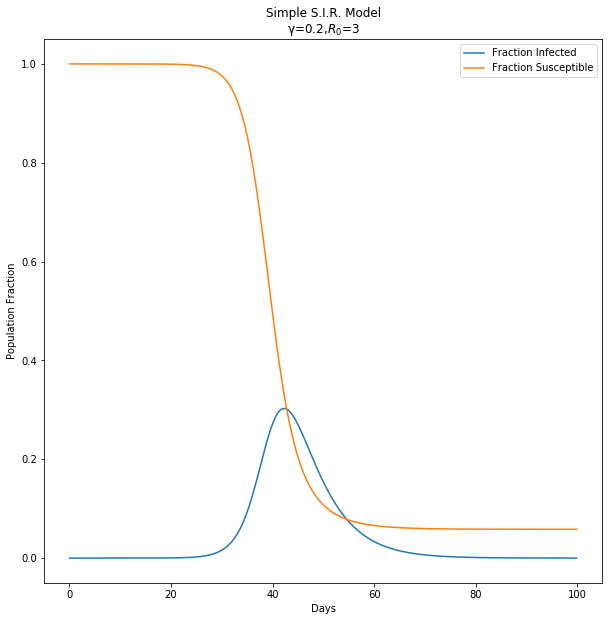

In [48]:
fig,ax = plt.subplots(figsize=(10,10))
sns.lineplot(ts,np.array(Is)/N,ax=ax,label="Fraction Infected")
sns.lineplot(ts,np.array(Ss)/N,ax=ax,label="Fraction Susceptible")
ax.legend()
ax.set_xlabel("Days")
ax.set_ylabel("Population Fraction")
ax.set_title(f"Simple S.I.R. Model\nγ={γ},$R_0$={R0}")